<a href="https://colab.research.google.com/github/martharskaty/bangkit-capstone-project-skinny-app/blob/main/Project_Bangkit23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Klasifikasi Penyakit Kulit (Eksim, Herpes, Kurap, Panu, BlackHead, Milia, Jerawat, Flek Hitam)**

Memasukkan Library yang dibutuhkan

In [33]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [34]:
import os
from shutil import copy2
import csv

In [35]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [36]:
import tensorflow_hub as hub

In [37]:
tf.__version__

'2.12.0'

In [38]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [39]:
data_root = ("/content/gdrive/MyDrive/Capstone_project/Dataset_2.zip") 

In [40]:
#Mengekstak file Zip
import zipfile #tambahkan library agar bisa ekstrak zip
local_zip = data_root
extract_zip = zipfile.ZipFile(local_zip, 'r')
extract_zip.extractall('')
extract_zip.close()

In [41]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = os.path.join('Dataset_2/train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                      rescale=1./255, 
                      validation_split=.20, 
                      rotation_range = 20,
                      horizontal_flip = True,
                      shear_range = 0.2,
                      zoom_range = 0.2,    
                      vertical_flip = True,
                      fill_mode = "nearest")

train_generator = datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)


valid_generator = datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

#Memuat dataset pengujian
x_test = []
y_test = []
labels = ['BlackHead', 'Eksim', 'FlekHitam', 'Herpes', 'Jerawat', 'Kurap', 'Milia', 'Panu']

for i,label in enumerate(labels):
  folder = os.path.join('Dataset_2/test', label)
  files = sorted(os.listdir(folder))
  files = [x for x in files if x.endswith(".jpg")]
  for k, file in enumerate(files):
    image_path = os.path.join(folder, file)

    image = imread(image_path)/255.
    image = resize(image, (224, 224))
    x_test.append(image)
    category = os.path.split(folder)[-1]
    y_test.append(i)

x_test = np.array(x_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print('Bentuk array dari dataset train (pelatihan) adalah', image_batch.shape,label_batch.shape)
for image_batch, label_batch in valid_generator:
  break
print('Bentuk array dari dataset validation (validasi) adalah', image_batch.shape,label_batch.shape)
print('Bentuk array dari dataset test (pengujian) adalah', x_test.shape,y_test.shape)

Found 786 images belonging to 8 classes.
Found 193 images belonging to 8 classes.
Bentuk array dari dataset train (pelatihan) adalah (32, 224, 224, 3) (32, 8)
Bentuk array dari dataset validation (validasi) adalah (32, 224, 224, 3) (32, 8)
Bentuk array dari dataset test (pengujian) adalah (39, 224, 224, 3) (39,)


In [42]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'Blackhead': 0, 'Eksim': 1, 'FlekHitam': 2, 'Herves': 3, 'Jerawat': 4, 'Kurap': 5, 'Milia': 6, 'Panu': 7}


In [43]:
!cat labels.txt

Blackhead
Eksim
FlekHitam
Herves
Jerawat
Kurap
Milia
Panu

Membuat Model dari Jaringan CNN yang sudah dipelajari Sebelumnya (pre-trained convnets)

In [44]:
base_model = hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/classification/2",
                            output_shape=[1000],
                            trainable=False)

Mengelompokkan Klasifikasi 8 Jenis Penyakit Kulit dengan *Deep Learning (CNN)*

In [45]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

Mempersiapkan Data Pengujian

In [46]:
y_test2 = to_categorical(y_test)
x_test3, y_test3 = (x_test, y_test2)

In [47]:
model = tf.keras.Sequential([
    base_model,
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

model.build([None, 224, 224, 3])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1000)              14467622  
                                                                 
 dense_12 (Dense)            (None, 512)               512512    
                                                                 
 dense_13 (Dense)            (None, 8)                 4104      
                                                                 
Total params: 14,984,238
Trainable params: 516,616
Non-trainable params: 14,467,622
_________________________________________________________________


In [48]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [49]:
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['acc']
)

Pelatihan

In [50]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator,
    epochs=50,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/50
25/25 [==============================] - 36s 932ms/step - loss: 1.7943 - acc: 0.4046 - val_loss: 1.4217 - val_acc: 0.5389
Epoch 2/50
25/25 [==============================] - 23s 906ms/step - loss: 1.1028 - acc: 0.6425 - val_loss: 1.2123 - val_acc: 0.5855
Epoch 3/50
25/25 [==============================] - 22s 874ms/step - loss: 0.8571 - acc: 0.7354 - val_loss: 1.0686 - val_acc: 0.6839
Epoch 4/50
25/25 [==============================] - 22s 903ms/step - loss: 0.7532 - acc: 0.7557 - val_loss: 1.0305 - val_acc: 0.6943
Epoch 5/50
25/25 [==============================] - 21s 828ms/step - loss: 0.6620 - acc: 0.7735 - val_loss: 0.9284 - val_acc: 0.7202
Epoch 6/50
25/25 [==============================] - 22s 897ms/step - loss: 0.5947 - acc: 0.8079 - val_loss: 0.9063 - val_acc: 0.7306
Epoch 7/50
25/25 [==============================] - 21s 829ms/step - loss: 0.5480 - acc: 0.8308 - val_loss: 0.8830 - val_acc: 0.7047
Epoch 8/50
25/25 [==============================] - 22s 881ms/step - 

In [51]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

7/7 [==============================] - 5s 725ms/step - loss: 0.8351 - acc: 0.7668
Final loss: 0.84
Final accuracy: 76.68%


<Figure size 640x480 with 0 Axes>

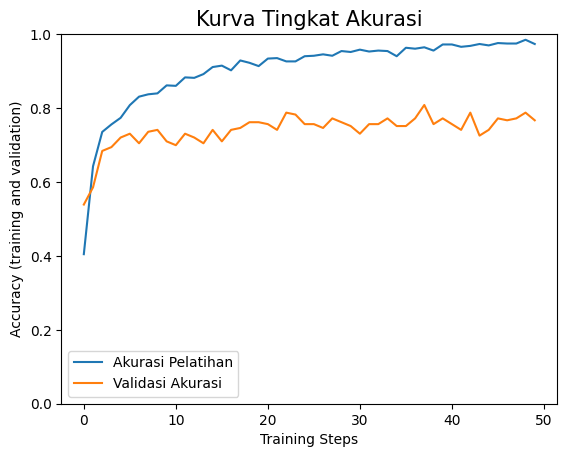

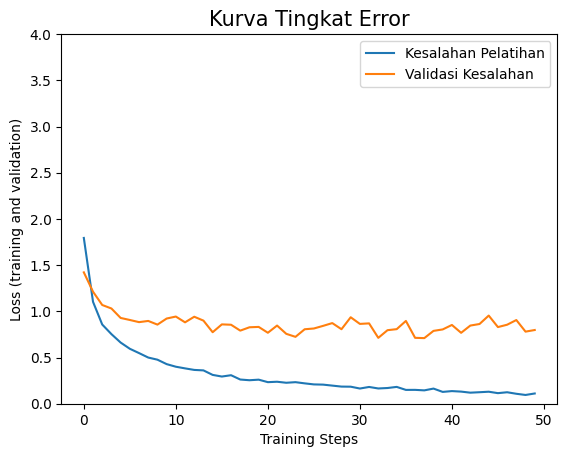

<Figure size 640x480 with 0 Axes>

In [52]:
plt.title("Kurva Tingkat Akurasi", size=15)
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"], label='Akurasi Pelatihan')
plt.plot(hist["val_acc"], label='Validasi Akurasi')
plt.legend()
plt.figure()

plt.title("Kurva Tingkat Error", size=15)
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,4])
plt.plot(hist["loss"], label='Kesalahan Pelatihan')
plt.plot(hist["val_loss"], label='Validasi Kesalahan')
plt.legend()
plt.figure()

Evaluasi

In [53]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data test
print(model.evaluate(x = x_test3, y=y_test3))

['loss', 'acc']
2/2 [==============================] - 1s 672ms/step - loss: 0.3349 - acc: 0.8718
[0.33492782711982727, 0.8717948794364929]


In [54]:
#Menampilkan matriks yang benar dan matriks hasil prediksi 

#Label yang benar 
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_true)

2/2 [==============================] - 1s 76ms/step
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 7 7 7
 7 7]
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 7 7 7
 7 7]


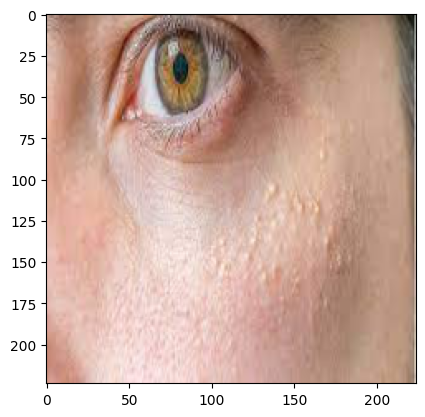

Label yang benar adalah: 6 : e
1/1 [==============================] - 0s 30ms/step
Nilai yang diprediksi adalah: [5.1994054e-03 3.9472640e-02 2.4278555e-02 1.2230716e-02 7.6154489e-03
 1.9900349e-03 9.0908873e-01 1.2441052e-04]
Label yang diprediksi adalah: 6 : e
Prediksi benar


In [55]:
n = 30 #Jangan melampaui (nilai dari gambar test -1)

plt.imshow(x_test[n])
plt.show()

true_label = np.argmax(y_test2, axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(x_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print('Label yang diprediksi adalah:', predicted_label, ":", labels[predicted_label])
if true_label == predicted_label:
  print('Prediksi benar')
else:
  print('Prediksi salah')

Normalized confusion matrix
[[1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.2 0.  0.8 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.8 0.2 0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.4 0.  0.  0.  0.6 0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.2 0.  0.  0.  0.  0.  0.8]]
              precision    recall  f1-score   support

   BlackHead       0.83      1.00      0.91         5
       Eksim       0.62      1.00      0.77         5
   FlekHitam       1.00      0.80      0.89         5
      Herpes       1.00      0.80      0.89         5
     Jerawat       0.83      1.00      0.91         5
       Kurap       1.00      0.60      0.75         5
       Milia       1.00      1.00      1.00         4
        Panu       1.00      0.80      0.89         5

    accuracy                           0.87        39
   macro avg       0.91      0.88      0.88        39
weighted avg       0.91      0.87      0.87        39



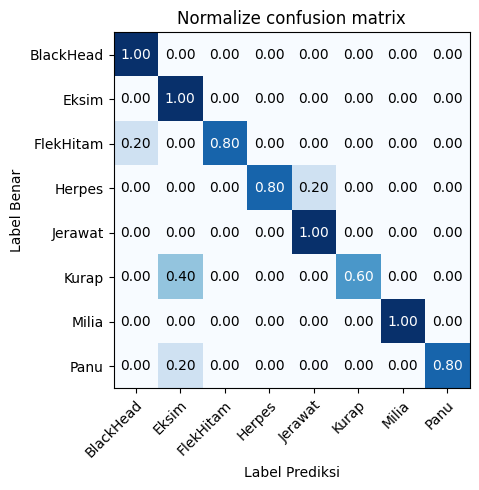

In [56]:
from scipy.interpolate import interpolate
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

  if not title:
    if normalize:
      title = "Normalize confusing matrix"
    else:
      title = "Confusing matrix, without normalization"
  
  #Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  #Only use the lables that appear in the data
  #classes = classes[unique_lables(y_true, y_pred)]
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  fig, ax = plt.subplots(figsize=(5,5))
  im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
  #ax.figure.colorbar(im, ax=ax)
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         #...and label them with the respective list entries
         xticklabels=classes, yticklabels=classes,
         title=title,
         ylabel='Label Benar',
         xlabel='Label Prediksi')

  #Rotate the tick labels and set their alignment
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")
  
  #Loop over data dimension and create text annotation
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j, i, format(cm[i, j], fmt),
              ha = 'center', va = 'center',
              color = 'white' if cm[i,j] > thresh else 'black')
  fig.tight_layout()
  return ax

np.set_printoptions(precision=2)

labels = ['BlackHead', 'Eksim', 'FlekHitam', 'Herpes', 'Jerawat', 'Kurap', 'Milia', 'Panu']

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalize confusion matrix')

print(classification_report(y_true, y_pred, target_names=labels))

Checking the performance

In [57]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [58]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Blackhead' 'Eksim' 'Flekhitam' 'Herves' 'Jerawat' 'Kurap' 'Milia' 'Panu']


In [59]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

1/1 [==============================] - 0s 40ms/step
Prediction results shape: (32, 8)


In [60]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Eksim' 'Flekhitam' 'Eksim' 'Blackhead' 'Jerawat' 'Eksim' 'Eksim'
 'Jerawat' 'Flekhitam' 'Jerawat' 'Jerawat' 'Jerawat' 'Blackhead' 'Eksim'
 'Eksim' 'Panu' 'Panu' 'Herves' 'Flekhitam' 'Milia' 'Milia' 'Panu' 'Eksim'
 'Eksim' 'Panu' 'Eksim' 'Panu' 'Panu' 'Eksim' 'Panu' 'Blackhead' 'Herves']


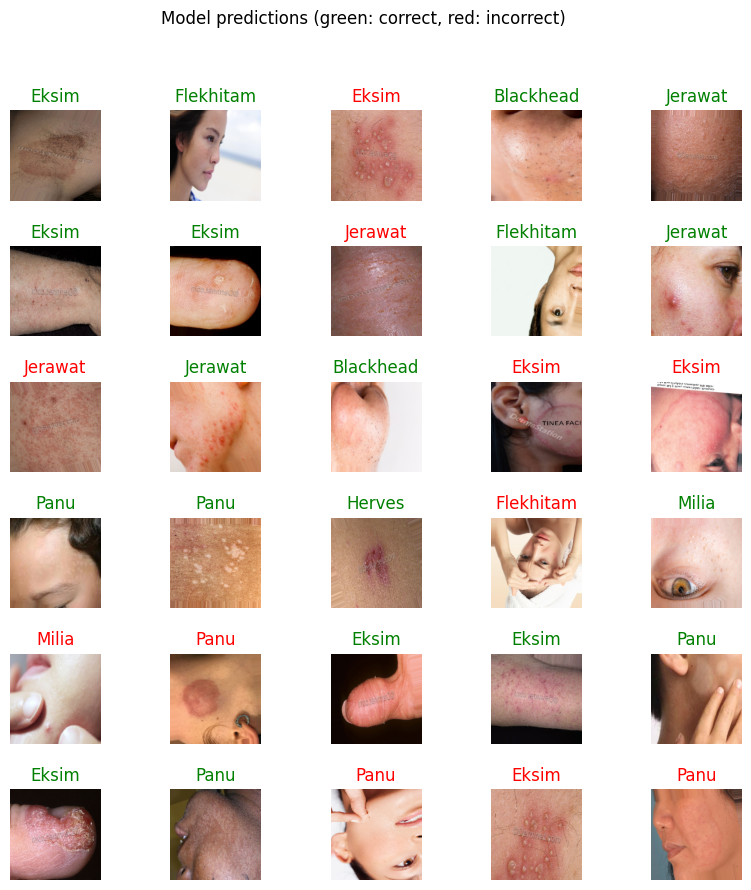

In [61]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [64]:
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

tfmodel = converter.convert()
open('skinny5.tflite', 'wb').write(tfmodel)

16136528

In [65]:
model.save('model5.h5')